In [1]:
import pandas as pd
import numpy as np

In [2]:
inflation = pd.read_excel('CPI Y o Y United States of America Monthly Economic Time Series Profile.xls', sheet_name = 'inflation')
inflation.date = pd.to_datetime(inflation.date, '%Y-%m-%d')
#inflation.set_index('date', inplace = True)

inflation_Jan1974_Oct2006 = inflation.loc[(inflation['date'] > '1973-12-31') & (inflation['date'] < '2006-11-30')]
inflation_Jan1974_Oct2006

,date,values
720,1974-01-31,9.39
721,1974-02-28,10.02
722,1974-03-31,10.39
723,1974-04-30,10.09
724,1974-05-31,10.71
...,...,...
1109,2006-06-30,4.32
1110,2006-07-31,4.15
1111,2006-08-31,3.82
1112,2006-09-30,2.06


In [3]:
treasury_rate = pd.read_excel('CM_1year.xls', sheet_name = 'values')
treasury_rate.date = pd.to_datetime(treasury_rate['date'])

treasury_rate_Jan1974_Oct2006 = treasury_rate.loc[(treasury_rate['date'] > '1974-01-01') & (treasury_rate['date'] < '2006-12-01')]
treasury_rate_Jan1974_Oct2006

,date,rates
49,1974-02-01,6.883333
50,1974-03-01,7.759524
51,1974-04-01,8.621905
52,1974-05-01,8.782273
53,1974-06-01,8.669500
...,...,...
438,2006-07-01,5.217500
439,2006-08-01,5.082609
440,2006-09-01,4.974500
441,2006-10-01,5.010000


In [4]:
from statsmodels.tsa.stattools import adfuller

<AxesSubplot:xlabel='date', ylabel='values'>

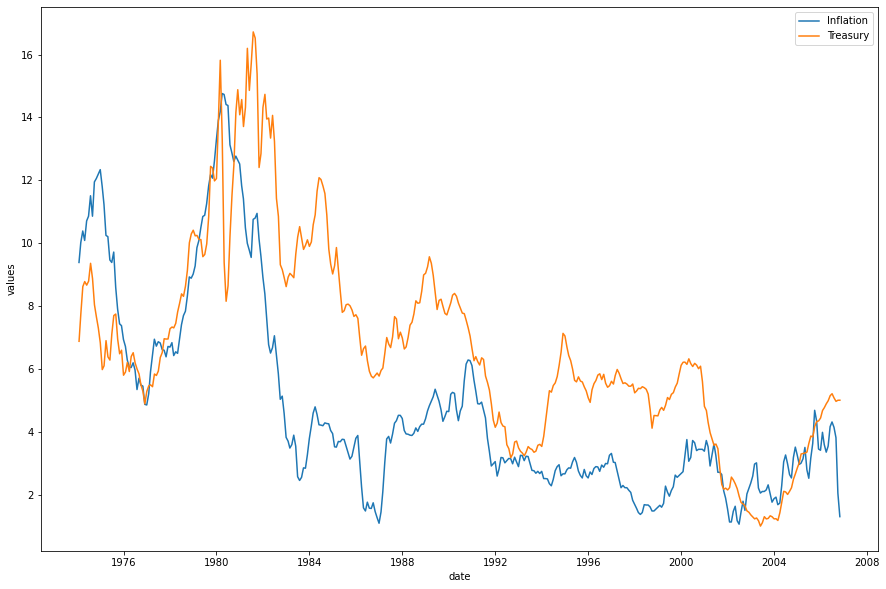

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


plt.figure(figsize=(15,10))
sns.lineplot(x ='date', y='values', data = inflation_Jan1974_Oct2006, label = 'Inflation')
sns.lineplot(x = 'date', y = 'rates', data = treasury_rate_Jan1974_Oct2006, label = 'Treasury')


### Test for stationarity on treasury rates (table 1)

In [6]:
treasury_rate_StationaryTest = adfuller(treasury_rate_Jan1974_Oct2006['rates'])

print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(treasury_rate_StationaryTest,labels):
    print(label+' : '+str(value) )
    
if treasury_rate_StationaryTest[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Indicating it is a non stochastic process")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is a stochastic process ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.1532997898558333
p-value : 0.22362914981009813
#Lags Used : 17
Number of Observations Used : 376
weak evidence against null hypothesis, time series has a unit root, indicating it is a stochastic process 


### Test for stationarity on inflation index (table 1)

In [7]:
inflation_index = adfuller(inflation_Jan1974_Oct2006['values'])

print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(inflation_index,labels):
    print(label+' : '+str(value) )
    
if inflation_index[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Indicating it is a non stochastic process")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is a stochastic process ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.252290174091855
p-value : 0.1878170639523276
#Lags Used : 15
Number of Observations Used : 378
weak evidence against null hypothesis, time series has a unit root, indicating it is a stochastic process 


## cointegration

In [8]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as bg
from scipy.stats import chisquare

### `treasury rates against inflation`

In [9]:
regression_treasury_inflation = sm.OLS(treasury_rate_Jan1974_Oct2006['rates'].to_list(), sm.add_constant(inflation_Jan1974_Oct2006['values'].to_list())).fit()
regression_treasury_inflation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     325.4
Date:                Thu, 06 May 2021   Prob (F-statistic):           2.15e-53
Time:                        22:36:17   Log-Likelihood:                -895.56
No. Observations:                 394   AIC:                             1795.
Df Residuals:                     392   BIC:                             1803.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4363      0.215     15.968      0.000       3.013       3.859
x1             0.6816      0.038     18.038      0.000       0.607       0.756
==============================================================================
Omnibus:                        9.840   Durbin-Watson:                   0.055
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.193
Skew:                           0.393   Prob(JB):                      0.00612
Kurtosis:                       2.952   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
bg_treasury = bg(regression_treasury_inflation)

print('Lagrange Multiplier Test for autocorrelation of residuals')
labels = ['LM Test Statistic','LM p-value','LM F-test statistics','LM F-test p-value']
for value,label in zip(bg_treasury,labels):
    print(label+' : '+str(value) )
    
if bg(regression_treasury_inflation)[1] < chisquare(treasury_rate_Jan1974_Oct2006['rates'])[1]:
    print('Do not reject null hypothesis. Conclude there is no evidence of heteroskedasticity.')
else:
    print('Reject null hypothesis. Conclude there is evidence of hetereoskedasticity')

Lagrange Multiplier Test for autocorrelation of residuals
LM Test Statistic : 376.5198945680405
LM p-value : 2.999047400356786e-70
LM F-test statistics : 506.18788066182873
LM F-test p-value : 6.141769935220652e-243
Do not reject null hypothesis. Conclude there is no evidence of heteroskedasticity.


C:\Users\ghxye\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:826: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setnlags or period to silence this warning.
  warnings.warn("The default value of nlags is changing.  After 0.12, "


<b>We have ensured that comparisons between treasury interest rates to the inflation rate is homoskedastic</b>

In [11]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank as scr

## cointegrating relationship between treasury rate and inflation test result

In [12]:
inflation_treasury = pd.concat([treasury_rate_Jan1974_Oct2006.reset_index()['rates'], inflation_Jan1974_Oct2006.reset_index()['values']], axis=1)
inflation_treasury

,rates,values
0,6.883333,9.39
1,7.759524,10.02
2,8.621905,10.39
3,8.782273,10.09
4,8.669500,10.71
...,...,...
389,5.217500,4.32
390,5.082609,4.15
391,4.974500,3.82
392,5.010000,2.06


___________
## T-stats of treasury rates and inflation
<b> table 2 </b>

In [13]:
jci_TR_infl = coint_johansen(inflation_treasury, 0, 10)
maxEigen_stats_criticalValues_treasury_inflation = pd.DataFrame(jci_TR_infl.lr2, columns = ['J max'])
trace_stats_treasury_inflation = pd.DataFrame(jci_TR_infl.lr1, columns = ['J Trace'])

cointegration_results = pd.concat([trace_stats_treasury_inflation, maxEigen_stats_criticalValues_treasury_inflation], axis=1)
cointegration_results

,J Trace,J max
0,25.047475,20.715376
1,4.332100,4.332100


<b> table 3 </b>

In [14]:
scr_TR_infl = scr(inflation_treasury, 0, 10, method = 'maxeig', signif = 0.05)
scr_TR_infl.summary()

r_0,r_1,test statistic,critical value
0,1,20.72,14.26
1,2,4.332,3.841


_______________
### Analysis 2006 - 2020

In [15]:
inflation_06_19 = inflation.loc[(inflation['date'] > '2006-10-31') & (inflation['date'] < '2020-01-01')]
inflation_06_19

,date,values
1114,2006-11-30,1.97
1115,2006-12-31,2.54
1116,2007-01-31,2.08
1117,2007-02-28,2.42
1118,2007-03-31,2.78
...,...,...
1267,2019-08-31,1.75
1268,2019-09-30,1.71
1269,2019-10-31,1.76
1270,2019-11-30,2.05


In [16]:
treasury_rate_monthly_1 = treasury_rate.loc[(treasury_rate['date'] > '2006-11-01') & (treasury_rate['date'] < '2020-02-01')]
treasury_rate_monthly_1

,date,rates
443,2006-12-01,4.941500
444,2007-01-01,5.057143
445,2007-02-01,5.053684
446,2007-03-01,4.920455
447,2007-04-01,4.932381
...,...,...
596,2019-09-01,1.796000
597,2019-10-01,1.608182
598,2019-11-01,1.567895
599,2019-12-01,1.549048


<AxesSubplot:xlabel='date', ylabel='values'>

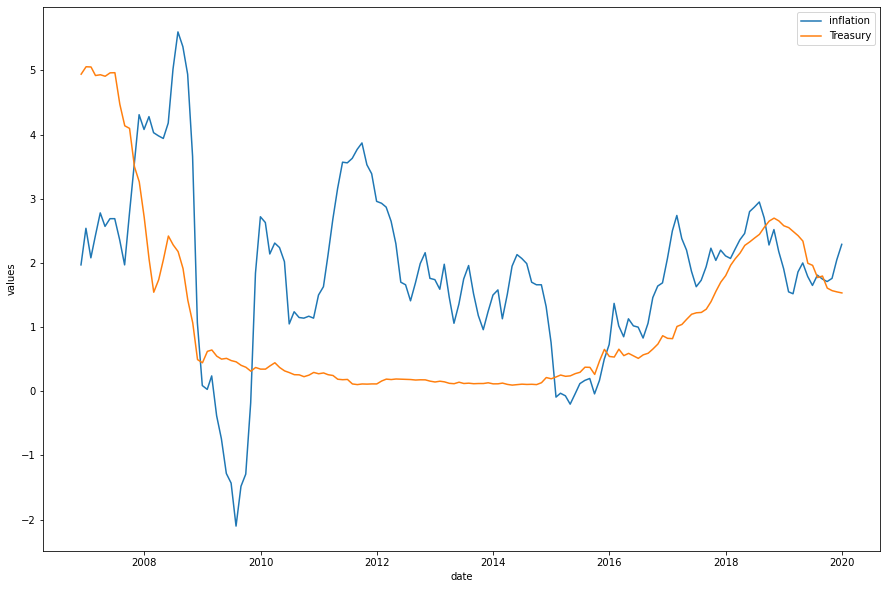

In [17]:
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y='values', data=inflation_06_19, label='inflation')
sns.lineplot(x='date', y='rates', data=treasury_rate_monthly_1, label='Treasury')

In [18]:
treasuryRate1_inflation1 = pd.concat([treasury_rate_monthly_1.reset_index().drop(['date', 'index'], axis=1), inflation_06_19.reset_index().drop(['date', 'index'], axis=1).reset_index()], axis = 1)
treasuryRate1_inflation1.drop('index', axis = 1, inplace=True)
treasuryRate1_inflation1

,rates,values
0,4.941500,1.97
1,5.057143,2.54
2,5.053684,2.08
3,4.920455,2.42
4,4.932381,2.78
...,...,...
153,1.796000,1.75
154,1.608182,1.71
155,1.567895,1.76
156,1.549048,2.05


In [19]:
regression_treasury1_inflation1 = sm.OLS(treasuryRate1_inflation1['rates'], sm.add_constant(treasuryRate1_inflation1.iloc[:,1])).fit()
regression_treasury1_inflation1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rates   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     23.30
Date:                Thu, 06 May 2021   Prob (F-statistic):           3.27e-06
Time:                        22:36:18   Log-Likelihood:                -255.18
No. Observations:                 158   AIC:                             514.4
Df Residuals:                     156   BIC:                             520.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4506      0.170      2.648      0.009       0.114       0.787
values         0.3627      0.075      4.827      0.000       0.214       0.511
==============================================================================
Omnibus:                       47.747   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.725
Skew:                           1.467   Prob(JB):                     2.43e-19
Kurtosis:                       5.101   Cond. No.                         4.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
bg_treasury1 = bg(regression_treasury1_inflation1)

print('Lagrange Multiplier Test for autocorrelation of residuals')
labels = ['LM Test Statistic','LM p-value','LM F-test statistics','LM F-test p-value']
for value,label in zip(bg_treasury1,labels):
    print(label+' : '+str(value) )
    
if bg(regression_treasury1_inflation1)[1] < chisquare(treasuryRate1_inflation1['rates'])[1]:
    print('Do not reject null hypothesis. Conclude there is no evidence of heteroskedasticity.')
else:
    print('Reject null hypothesis. Conclude there is evidence of hetereoskedasticity')

Lagrange Multiplier Test for autocorrelation of residuals
LM Test Statistic : 145.5203132812552
LM p-value : 1.6424236339399798e-24
LM F-test statistics : 128.26631646846533
LM F-test p-value : 6.698840081036544e-72
Do not reject null hypothesis. Conclude there is no evidence of heteroskedasticity.


C:\Users\ghxye\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:826: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setnlags or period to silence this warning.
  warnings.warn("The default value of nlags is changing.  After 0.12, "


In [21]:
jci_TR1_infl = coint_johansen(treasuryRate1_inflation1, 0, 10)
jci_TR1_infl
maxEigen_stats_criticalValues_treasury_inflation_1 = pd.DataFrame(jci_TR1_infl.lr2, columns = ['J max'])
trace_stats_treasury_inflation_1 = pd.DataFrame(jci_TR1_infl.lr1, columns = ['J Trace'])

cointegration_results_1 = pd.concat([trace_stats_treasury_inflation_1, maxEigen_stats_criticalValues_treasury_inflation_1], axis=1)
cointegration_results_1

,J Trace,J max
0,24.055904,13.208589
1,10.847315,10.847315


In [22]:
scr_TR_infl_1 = scr(treasuryRate1_inflation1, 0, 10, method = 'maxeig', signif = 0.05)
scr_TR_infl_1.summary()

r_0,r_1,test statistic,critical value
0,1,13.21,14.26
